# Project Aldrin
This notebook aims to walk you through the steps of creating a H2O model for EArnix consumption. It includes features selection, evaluation and graph output for analysis purposes.

The research and development process contains many exploration steps and repetitive refinement that are not required in production.

**Note:** Please refer to `train.ipynb` for production need.

In [1]:
import h2o
h2o.init(nthreads=-1,max_mem_size='4g')

from h2o.estimators import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator # Not working on current version
from h2o.estimators.random_forest import H2ORandomForestEstimator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import sys, os
scriptPath = os.path.realpath(os.path.dirname(sys.argv[0]))
sys.path.append("../")

import warnings
warnings.filterwarnings('ignore')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.281-b09, mixed mode)
  Starting server from C:\Users\mleong\Anaconda3\envs\dev\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\mleong\AppData\Local\Temp\tmpoicht83y
  JVM stdout: C:\Users\mleong\AppData\Local\Temp\tmpoicht83y\h2o_mleong_started_from_python.out
  JVM stderr: C:\Users\mleong\AppData\Local\Temp\tmpoicht83y\h2o_mleong_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Australia/Brisbane
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,"1 year, 5 months and 17 days !!!"
H2O_cluster_name:,H2O_from_python_mleong_1zc3yr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


## 1. Preparing Data
Data is imported as pandas data-frame instead of H2Oframe due to the H2O framework being incompatible with the interface with bigquery and other python native packages (eg. matplotlib, sklearn & etc...).

You will see me converting back and forth in this notebook between the pd data-frame and H2Oframe.

In [2]:
from Data_Handler import logging
from Data_Handler.Import_Data import import_data
import_cls = import_data()
df = import_cls.df

Count the percentage of blanks in each attribute. If blanks exceeded 40%, we manually remove them in the SQL steps to avoid importing.

In [3]:
#pd.options.display.max_rows = 500
#df.isnull().sum() * 100 / len(df)

I have renamed the column `partnerrankposition` to `target` to be compatible with other python packages developed for other projects.

In [4]:
df.rename(columns={'partnerrankposition' : 'target'}, inplace=True) 

Saving figure RankPosition


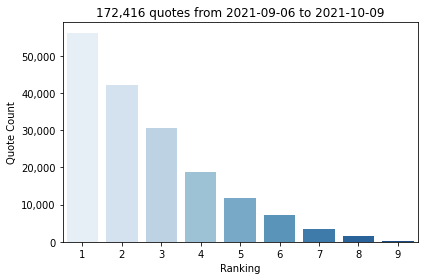

In [5]:
import seaborn as sns
import matplotlib as mpl

plt.figure()
sns.countplot(x='target', data=df, palette='Blues')
plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
logging.save_fig('RankPosition')
plt.xlabel("Ranking")
plt.ylabel("Quote Count")
plt.title('{:,} quotes from 2021-09-06 to 2021-10-09'.format(len(df)))
plt.tight_layout()
plt.show()

Target rank `#1` is the dominant class in the data set. The amount of data points in each rank is imbalanced, so this needs to be weighted during the training step.

## 2. Train Test Split
`sklearn-stratified-split` is used to split the data and ensure the `train_set` and `test_set` have the same distribution (e.g. similar proportion of classes in both data set).

Training weight is also calculated in this step.

In [6]:
from sklearn.model_selection import train_test_split
df['target'].value_counts(normalize=True)

1    0.326170
2    0.245424
3    0.177663
4    0.109079
5    0.069025
6    0.042206
7    0.020584
8    0.008375
9    0.001473
Name: target, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
                                     df,
                                     df['target'],
                                     test_size=0.3, 
                                     random_state=42,
                                     stratify = df['target']
                                                  )

In [8]:
X_train['weight'] = class_weight.compute_sample_weight( class_weight='balanced', y=X_train['target'])

In [9]:
X_train['target'].value_counts(normalize=True)
X_test['target'].value_counts(normalize=True)

1    0.326167
2    0.245433
3    0.177670
4    0.109077
5    0.069019
6    0.042204
7    0.020590
8    0.008371
9    0.001469
Name: target, dtype: float64

The distribution of the `test_set` looks identical to the initial dataset.

### Import to H2O frame

In [10]:
hf_train = h2o.H2OFrame(X_train)
hf_test = h2o.H2OFrame(X_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [11]:
hf_train['target'] = hf_train['target'].asfactor()
hf_test['target'] = hf_test['target'].asfactor()

In [12]:
hf_train.describe()

Rows:120691
Cols:107




,policy_sold,target,ACCELERATION,ACCESSORIES_VALUE,ADDITIONAL_EXCESS_AMOUNT,ALARM_IMMOBILISER,ALLOWED_DRIVER_COUNT,ANCAP_RATING,BASIC_EXCESS,BODY_ENGINE_MODIFIED,BODY_STYLE,BUILD_COUNTRY_ORIGIN,BULL_BAR_FITTED,CATCHMENT_AREA,COVER_TYPE,DAYS_TO_COMMENCEMENT,DRIVE_TYPE,DRIVER_OPTION,DRIVERS_AGE_DIFFERENCE,ENGINE_TYPE,ENGINE_TYPE_NEW,FACTORY_OPTIONS_VALUE,FINANCE_TYPE,FUEL_TYPE,GLOBAL_OWN_DAMAGE_CATEGORY,HAS_PREVIOUS_INSURANCE,HOME_OWNERSHIP,INSPECTION_WOULD_BE_REQUIRED,INSURED_VALUE,MARKET_AGREED,METHOD_OF_PARKING,MODIFICATION_LOADING_FACTOR,NCD,NEW_PRICE,NUMBER_OF_CYLINDERS,ONLINE_DISCOUNT_PERCENTAGE,OWN_DAMAGE_VEHICLE_CATEGORY,POSTCODE,POWER,POWER_TO_WEIGHT_RATIO,RATING_AREA_OWN_DAMAGE,RATING_AREA_THEFT,RATING_AREA_THIRD_PARTY,RATING_AREA_WEATHER,RATING_AREA_WINDOWGLASS,RD_AGE,RD_CLAIM_COUNT_5YR,RD_GENDER,RD_HAS_PREVIOUS_CLAIMS,RD_IS_YDNL,RD_LICENCE_HELD_MONTHS,RD_LICENCE_TYPE,RD_OTHER_VEHICLE,REGULAR_DRIVER_IS_YOUNGEST,SEAT_CAPACITY,STATE_CODE,SUBURB_SEQUENCE,THIRD_PARTY_VEHICLE_CATEGORY,TORQUE,TRANSMISSION_DESCRIPTION,TRANSMISSION_TYPE,UNDERWRITER_PRODUCT,USE_CODE,VEHCAT_OD_FREQ,VEHCAT_OD_SEV,VEHCAT_TH_FREQ,VEHCAT_TH_SEV,VEHCAT_TP_FREQ,VEHCAT_TP_SEV,VEHICLE_AGE,VEHICLE_COLOUR,VEHICLE_KMS,VEHICLE_LENGTH,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_STATS_CODE,VFACTS_CLASS,VFACTS_PRICE,VFACTS_SEGMENT,WEIGHT,WINDOWGLASS_REPLACE_COST,WINDOWGLASS_VEHICLE_CATEGORY,YD_AGE,YD_GENDER,YD_LICENCE_HELD_MONTHS,YD_LICENCE_TYPE,YD_OTHER_VEHICLE,RISK_SUBURB,PREMIUM_COMMISSION_FACTOR,OD_FREQ,OD_COST,TP_FREQ,TP_COST,TH_FREQ,TH_COST,WE_FREQ,WE_COST,AE_FREQ,AE_COST,HC_FREQ,HC_COST,CH_COST,PC_CORVEH_FIN_PREM,TOTAL_PREMIUM,ACTUARIAL_COST,GROSS_MARGIN,weight
type,int,enum,real,int,int,enum,int,int,int,enum,enum,enum,enum,enum,enum,int,enum,enum,int,enum,enum,int,enum,enum,int,enum,enum,enum,int,enum,int,real,int,int,int,real,int,int,int,real,int,int,int,enum,enum,int,int,enum,enum,enum,int,int,enum,enum,int,enum,int,int,int,enum,enum,int,int,int,int,int,int,int,int,int,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,enum,int,int,enum,enum,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,0.0,,0.0,0.0,0.0,,1.0,0.0,500.0,,,,,,,0.0,,,0.0,,,0.0,,,0.0,,,,750.0,,1.0,1.0,0.0,0.0,0.0,-1.49,1.0,800.0,0.0,0.0,201.0,201.0,1.0,,,192.0,0.0,,,,0.0,1.0,,,0.0,,2.0,1.0,0.0,,,504.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,,,0.0,,,,,,,0.0,219.0,1.0,192.0,,0.0,1.0,,,0.15,0.0,0.0,0.0023122295,4.5653071043,0.000177467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6996220888,123.24,152.36,10.31,-64.62,0.34065211378120996
mean,0.09255039729557299,,2.744795386565692,134.07500144998383,218.49889386946836,,1.2068754091025844,3.5681616690556877,646.028287113372,,,,,,,6.942232643693399,,,30.714908319593018,,,134.97477856675312,,,8.58582661507486,,,,22626.273027814834,,2.654265852466215,1.0022795611106055,2.9902809654406703,39907.99199608919,4.377733219544126,-0.06734056391943061,6.462246563538292,3321.9601213015053,126.48291919032903,0.08118106569669653,322.1051031145654,322.1051031145654,313.82896819149727,,,496.3808237565352,0.15671425375545817,,,,9046.772791674606,1.1659361509971746,,,5.0502854396765295,,70148.6886926117,6.462246563538292,268.66566686828355,,,507.138469314199,2.860718694848829,4.107679942994921,3.9256282572851333,3.5556835223836076,3.940302093776669,3.461227432037186,2.3473912719258276,8.497485313735076,,,4522.13310023117,,,,,,,1549.7234673670778,423.1961372430422,1.7127374866394343,465.66625514744266,,8671.290841902046,1.2583539783413846,,,0.18533088631298103,0.08107184093404314,264.94493707835477,0.029711860252449644,154.78534264417155,0.0026069484802495628,19.810182148849304,0.005704407279488114,52.502594484056516,0.06488134558929663,13.443264514071133,0.04617997946708287,21.13545460420159,40.69729936657169,697.191775755057,867.5327842175473,480.67358585147196,210.25697085946757,0.9999999999999998
maxs,1.0,,24.9,16605.0,1200.0,,2.0,5.0,900.0,,,,,,,30.0,,,845.0,,,39900.0,,,36.0,,,,175000.0,,8.0,1.461657,5.0,557000.0,12.0,0.0,22.

## 3. Data Exploration
I am converting it back to pandas data-frame for exploration purposes.

In [13]:
df = hf_train.as_data_frame()

In [14]:
from Data_Explore import data_explore

data = data_explore(df)
data.info(df)    
data.dtypes_count(df)    
data.cardinality(df)
data.stats(df)
data.cor_matrix(df)

The above function generates a few files which contain helpful information in the `my_logs` directory:
1. `df_info.txt` contained schema information.
2. `dtypes.txt` contained total columns count by data types.
3. `cardinality.txt` contained cardinality distribution for each categorical attribute.
4. `stats.xlsx` contained statistical information such as percentile for each numerical variable.
5. `corr.xlsx` contained Pearson Correlation matrix. This step is repeated many times to ensure attribute with high correlation is not modelled concurrently.

## 4. Training H2O model

In [15]:
base = H2OGradientBoostingEstimator(seed=42)
base.train(y = 'target',
           ignored_columns=['policy_sold'],
           weights_column='weight',
           training_frame=hf_train,
           validation_frame = hf_test,
           model_id='base'
           )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [16]:
features_50 = base.varimp(use_pandas=True).head(50)
features_50.to_csv(import_cls.root_logdir + '\\top50Features.csv')

## 5. Preliminary Evaluation

gbm prediction progress: |████████████████████████████████████████████████| 100%


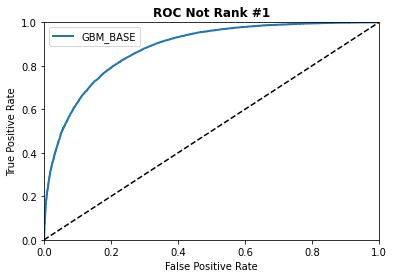

>>>>>>>>>>>>> MULTICLASS MODEL:GBM_BASE Confusion Matrix <<<<<<<<<
[[11499  2960  1245   476   311   194   122    57     7]
 [ 2716  5043  2247  1120   604   480   344   125    16]
 [  899  1979  2908  1379   777   638   384   195    31]
 [  252   732  1066  1579   766   656   394   165    32]
 [  105   240   407   558   971   590   446   220    33]
 [   22    66   145   226   290   789   382   209    54]
 [    0    17    26    57    98   207   452   172    36]
 [    0     1     5     7    16    52    52   271    29]
 [    0     1     0     1     1     6     7    20    40]]
-----------------------------------------
Weighted Multiclass ROC_AUC   : 67.11%
Specific Class Accuracy       : 45.53%


Precision and Recall of each individual class
recall    :  ['68.16%', '39.72%', '31.64%', '27.99%', '27.20%', '36.14%', '42.44%', '62.59%', '52.63%']
precision :  ['74.22%', '45.68%', '36.13%', '29.22%', '25.33%', '21.84%', '17.50%', '18.90%', '14.39%']
============== END ===================== 



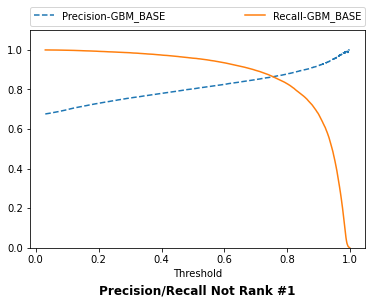

>>>>>>>>>>>>> BINARY MODEL:GBM_BASE Confusion Matrix <<<<<<<<<
[[11499  5372]
 [ 3994 30860]]


>>>>>>>>>>>>> GBM_BASE Positive Class - Not Rank #1) <<<<<<<<<
ROC_AUC   : 88.10%
Accuracy  : 81.89%
Precision : 85.17%
Recall    : 88.54%


In [17]:
from Evaluation import model_eval
metric = model_eval({'GBM_BASE'  : base}, hf_test)
metric.models_stats()

## 6. Removing Age and Gender Attribute

In [18]:
model_nodis = H2OGradientBoostingEstimator(seed=42)
model_nodis.train(y = 'target',
            ignored_columns=['policy_sold',                                # unrelated attribute
                             'YD_AGE','RD_AGE', 'DRIVERS_AGE_DIFFERENCE',  # Age discrimination
                             'RD_IS_YDNL','YD_LICENCE_HELD_MONTHS',
                             'YD_GENDER','RD_GENDER',                      # Gender discrimination
                             'ACTUARIAL_COST','TOTAL_PREMIUM'              # similar to PC_CORVEH_FIN_PREM
                            ],
            weights_column='weight',
            training_frame=hf_train,
            validation_frame = hf_test,
            model_id = 'no discrimination'
           )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


Double-check there are no Age or Gender discriminatory variables present in the model.

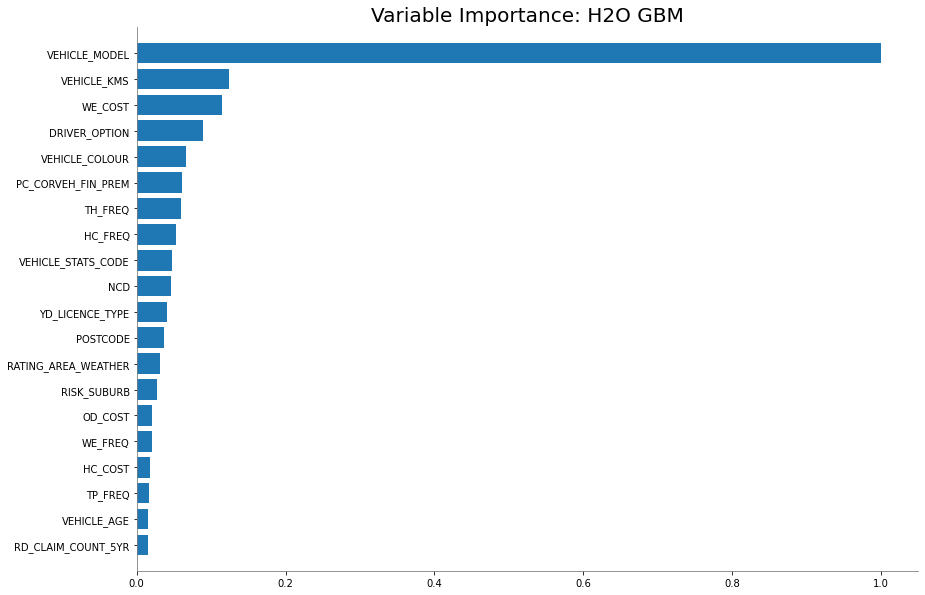

In [19]:
features_50 = model_nodis.varimp(use_pandas=True).head(50)
features_50.to_csv(import_cls.root_logdir + '\\top50Features.csv')
model_nodis.varimp_plot(num_of_features=20)
features_20 = model_nodis.varimp(use_pandas=True).head(20)

The model might be very sensitive to Vehicle_Model. It is not ideal to have a single variable that influences the model significantly. The attribute `VEHCILE_MODEL` have high cardinality and requires continuous monitoring to ensure no odd behaviour during production *(e.g. new model is added in the database)*.

In [20]:
top20_features = list(features_20['variable'])
top20_features.remove('RISK_SUBURB')         # replace RISK_SUBURB with SUBURB_SEQUENCE
# top20_features.append('SUBURB_SEQUENCE')   # remove SUBURB_SEQUENCE for this version due to unavailable                
top20_features.remove('VEHICLE_STATS_CODE')  # remove VEHICLE_STATS_CODE for this version due to unavailable

The Pearson Correlation heatmap below shows the variables used is independent of each other.

Saving figure Variables Corr


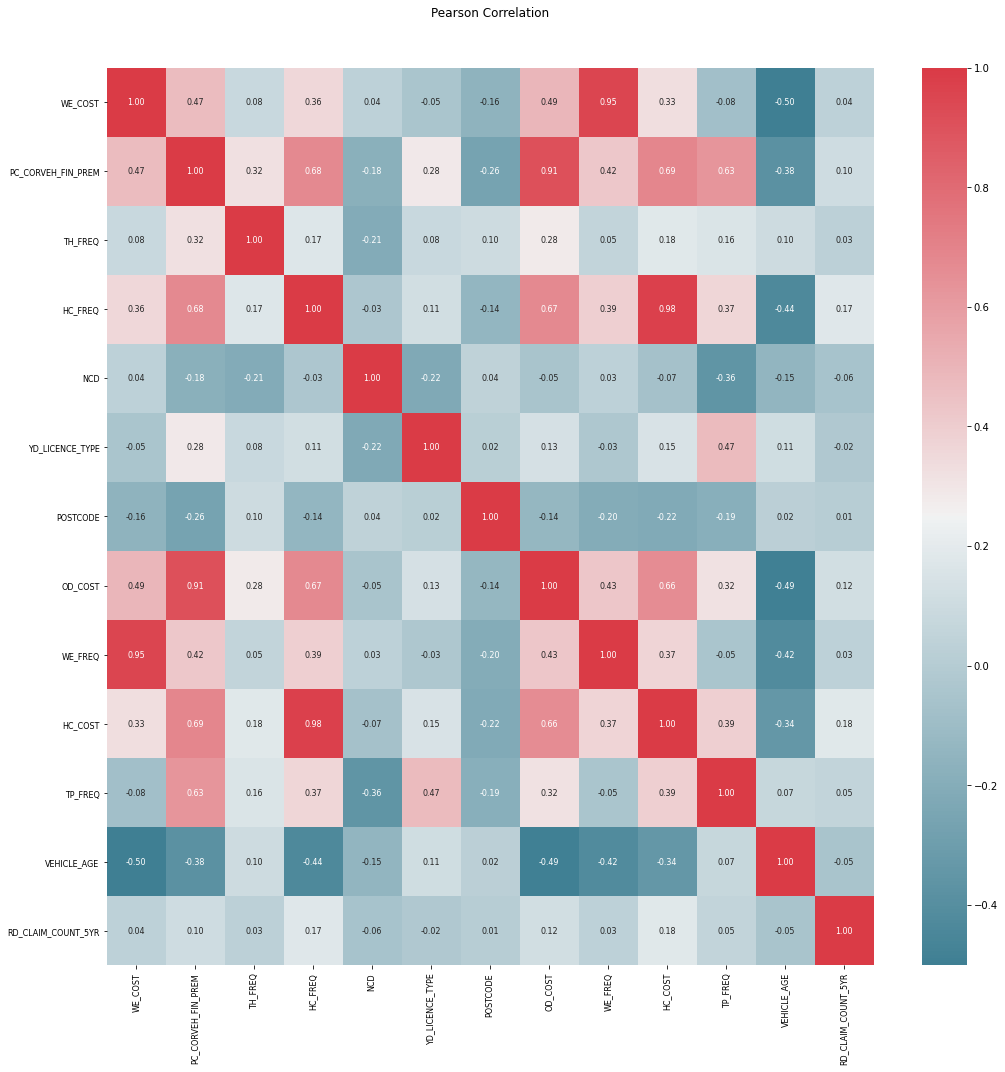

In [21]:
def correlation_heatmap(df):
    plt.figure(figsize=(15,15))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    #mask=np.zeros_like(df.corr())
    #mask[np.triu_indices_from(mask)] = True
    sns.heatmap(
                df.corr(), 
                cmap = colormap,
                #square=True,
                #mask=mask,
                cbar_kws={'shrink':1 },
                annot=True,vmax=1, 
                #linewidths=0.1, linecolor='white',
                annot_kws={'fontsize':8 },
                fmt='0.2f'
                )    
    plt.yticks(rotation=0, fontsize=8)
    plt.xticks(rotation=90, fontsize=8) 
    plt.title('Pearson Correlation', y=1.05, size=12)
    logging.save_fig('Variables Corr')
    #sns.set(font_scale=1.4)
    plt.tight_layout()

correlation_heatmap(df[top20_features])

Trim the model only to use top-50s or top-20s most essential attributes. The purpose here is to increase the inference speed with a minimal drop in predictive power.

In [22]:
# model are retrain with top-50s and top-20s variables.
top50 = H2OGradientBoostingEstimator(seed=42)
top50.train(x = list(features_50['variable']), y = 'target',
                weights_column='weight',
                training_frame=hf_train,
                validation_frame = hf_test,
                model_id='top50'
                )

top20 = H2OGradientBoostingEstimator(seed=42)
top20.train(x = top20_features, y = 'target',
                weights_column='weight',
                training_frame=hf_train,
                validation_frame = hf_test,
                model_id='top20'
                )

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%


gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


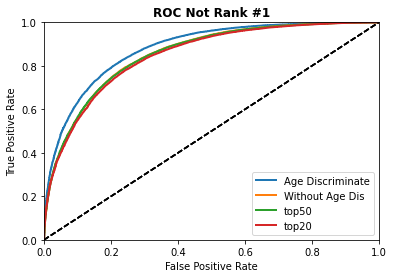

>>>>>>>>>>>>> MULTICLASS MODEL:Age Discriminate Confusion Matrix <<<<<<<<<
[[11499  2960  1245   476   311   194   122    57     7]
 [ 2716  5043  2247  1120   604   480   344   125    16]
 [  899  1979  2908  1379   777   638   384   195    31]
 [  252   732  1066  1579   766   656   394   165    32]
 [  105   240   407   558   971   590   446   220    33]
 [   22    66   145   226   290   789   382   209    54]
 [    0    17    26    57    98   207   452   172    36]
 [    0     1     5     7    16    52    52   271    29]
 [    0     1     0     1     1     6     7    20    40]]
-----------------------------------------
Weighted Multiclass ROC_AUC   : 67.11%
Specific Class Accuracy       : 45.53%


Precision and Recall of each individual class
recall    :  ['68.16%', '39.72%', '31.64%', '27.99%', '27.20%', '36.14%', '42.44%', '62.59%', '52.63%']
precision :  ['74.22%', '45.68%', '36.13%', '29.22%', '25.33%', '21.84%', '17.50%', '18.90%', '14.39%']
============== END ================

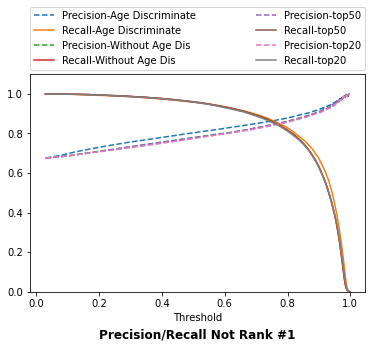

>>>>>>>>>>>>> BINARY MODEL:Age Discriminate Confusion Matrix <<<<<<<<<
[[11499  5372]
 [ 3994 30860]]


>>>>>>>>>>>>> Age Discriminate Positive Class - Not Rank #1) <<<<<<<<<
ROC_AUC   : 88.10%
Accuracy  : 81.89%
Precision : 85.17%
Recall    : 88.54%
>>>>>>>>>>>>> BINARY MODEL:Without Age Dis Confusion Matrix <<<<<<<<<
[[10970  5901]
 [ 4486 30368]]


>>>>>>>>>>>>> Without Age Dis Positive Class - Not Rank #1) <<<<<<<<<
ROC_AUC   : 85.54%
Accuracy  : 79.92%
Precision : 83.73%
Recall    : 87.13%
>>>>>>>>>>>>> BINARY MODEL:top50 Confusion Matrix <<<<<<<<<
[[10951  5920]
 [ 4524 30330]]


>>>>>>>>>>>>> top50 Positive Class - Not Rank #1) <<<<<<<<<
ROC_AUC   : 85.49%
Accuracy  : 79.81%
Precision : 83.67%
Recall    : 87.02%
>>>>>>>>>>>>> BINARY MODEL:top20 Confusion Matrix <<<<<<<<<
[[10802  6069]
 [ 4618 30236]]


>>>>>>>>>>>>> top20 Positive Class - Not Rank #1) <<<<<<<<<
ROC_AUC   : 84.88%
Accuracy  : 79.34%
Precision : 83.28%
Recall    : 86.75%


In [23]:
# comparing all models side by side
metric = model_eval({'Age Discriminate'  : base,
                     'Without Age Dis'   : model_nodis,
                     'top50'             : top50,
                     'top20'             : top20,
                     
                     }, hf_test)
metric.models_stats()

# Conclusion
1. The model without `AGE` and `GENDER` discrimination seems to perform slightly poorer in performance. Precision drop **1.84%** from 85.20% to 83.86%.

2. Trimming variables to the top 20s most essential seems to impact the specificity of the ranking. The impact to the current task is minimal, which is to identify quotes not rank #1 in the market - a much simpler task. Hence, the model is not suitable for predicting a specific ranking but perform reasonably well for the current job.

In [24]:
logging.dump_mojo(top20)

model saved in  .\MOJO\top20__2021-10-21 14.43.51.zip


# <<<<< END >>>>
## Appendix

# E. Earnix Implementation
Due to Earnix does not take a multinomial(**one-vs-all**) model we would need to train a **one-vs-one** binary model from the ground up.

The following procedure will repeat the entire process above.

In [24]:
from Data_Handler import logging
from Data_Handler.Import_Data import import_data
import_cls = import_data()
df = import_cls.df

In [25]:
df.rename(columns={'partnerrankposition' : 'target'}, inplace=True) 

### E1. Preparing Data as BINARY
We mask all label to zero except class-1.

In [26]:
conditions = [
        (df['target']==1), 
        (df['target']!=1)
        ]
choices = [1,0]  #rank above 1 is group into 0
df['target'] = np.select(conditions, choices, default=np.nan)

### E2. Train Test Split

In [27]:
from sklearn.model_selection import train_test_split
df['target'].value_counts(normalize=True)

0.0    0.67383
1.0    0.32617
Name: target, dtype: float64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
                                     df,
                                     df['target'],
                                     test_size=0.3, 
                                     random_state=42,
                                     stratify = df['target']
                                                  )
X_train['target'].value_counts(normalize=True)
X_test['target'].value_counts(normalize=True)

0.0    0.673833
1.0    0.326167
Name: target, dtype: float64

In [29]:
X_train['weight'] = class_weight.compute_sample_weight( class_weight='balanced', y=X_train['target'])

In [30]:
hf_train_B = h2o.H2OFrame(X_train)
hf_test_B = h2o.H2OFrame(X_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Below are the variables needed to encode in categorical variable due to Earnix constrain.

In [31]:
enum_ls = ['target','YD_LICENCE_TYPE','SUBURB_SEQUENCE']
for each in enum_ls:
    hf_train_B[each] = hf_train_B[each].asfactor()
    hf_test_B[each] = hf_test_B[each].asfactor()

In [32]:
X = ['VEHICLE_MODEL','VEHICLE_KMS','WE_COST','DRIVER_OPTION','VEHICLE_COLOUR','PC_CORVEH_FIN_PREM',
     'TH_FREQ','HC_FREQ','NCD','YD_LICENCE_TYPE','POSTCODE','OD_COST','WE_FREQ','HC_COST','TP_FREQ',
     'VEHICLE_AGE','RD_CLAIM_COUNT_5YR','ACCESSORIES_VALUE','TP_COST','STATE_CODE']

### E4. Training H2O model

In [33]:
model_ovo = H2OGradientBoostingEstimator(seed=42)
model_ovo.train(x = X, y = 'target',
             weights_column='weight',
             training_frame=hf_train_B,
             validation_frame = hf_test_B,
             model_id='OnevsOnetop20'
                )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


Before we cross-check everything is the same with the multnomial model, we import the result from the last output.

In [34]:
from Data_Handler.MyPickle import  load
plt_Data = load(import_cls.root_logdir + '\\plt_data - Multi.pkl')

Now overwrite it by calling the `model_eval`

gbm prediction progress: |████████████████████████████████████████████████| 100%


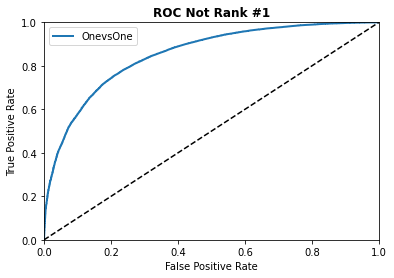

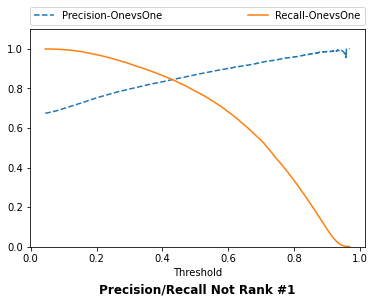

>>>>>>>>>>>>> BINARY MODEL:OnevsOne Confusion Matrix <<<<<<<<<
[[12868  4003]
 [ 7614 27240]]


>>>>>>>>>>>>> OnevsOne Positive Class - Not Rank #1) <<<<<<<<<
ROC_AUC   : 85.28%
Accuracy  : 77.54%
Precision : 87.19%
Recall    : 78.15%


In [35]:
metric = model_eval({'OnevsOne'  : model_ovo}, hf_test_B)
metric.models_stats()

In [36]:
#load the overwritten data back into memory and append into the dictionary
plt_Data_ovo = load(import_cls.root_logdir + '\\plt_data.pkl')
plt_Data['OnevsOne'] = plt_Data_ovo['OnevsOne'] 

### E5.Superimpose the plot to compare

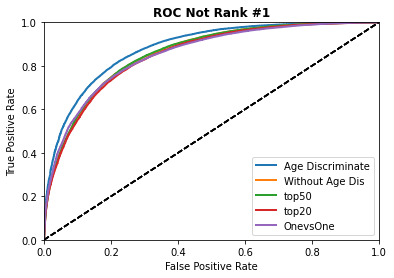

In [37]:
for i, (_id, item) in enumerate(plt_Data.items()):    
     model_eval.plot_roc_curve(item['fpr'], item['tpr'], label=_id)    
plt.show()

ROC-AUC look very similar. This is explained by the relatively same accuracy and ROC_AUC(fitness).

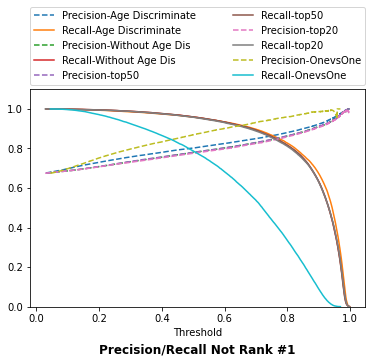

In [38]:
for i, (_id, item) in enumerate(plt_Data.items()):
    model_eval.plot_precision_recall_vs_threshold(item['precision'],
                                                  item['recalls'],
                                                  item['thresholds'],
                                                  _id)
plt.show()


|           | One-Vs-All  | One-vs-One  |
| --------- | ----------- | ----------- |
| Accuracy  | 79.40%      | 77.76%      |
| ROC-AUC   | 84.99%      | 85.36%      |
| Precision | 83.53%      | 87.14%      |
| Recall    | 86.48%      | 78.59%      |


Precision recall curve look very different. The **OVO** model had a lower false positve rate at the expense of higher false negative rate, in comparison with **OVA**.

**Note:**
1. False positive is where the model predicted a top quote as `not rank-#1`. This may result in eroding of profit, due to discounting on an already competitive segment.
2. False negative is where the model predict a bottom quote as `rank-#1`. This is a fail to react scenario, where opportunity is loss. 


In [39]:
logging.dump_mojo(model_ovo)

model saved in  .\MOJO\OnevsOnetop20__2021-10-28 11.36.25.zip


In [25]:
h2o.shutdown()